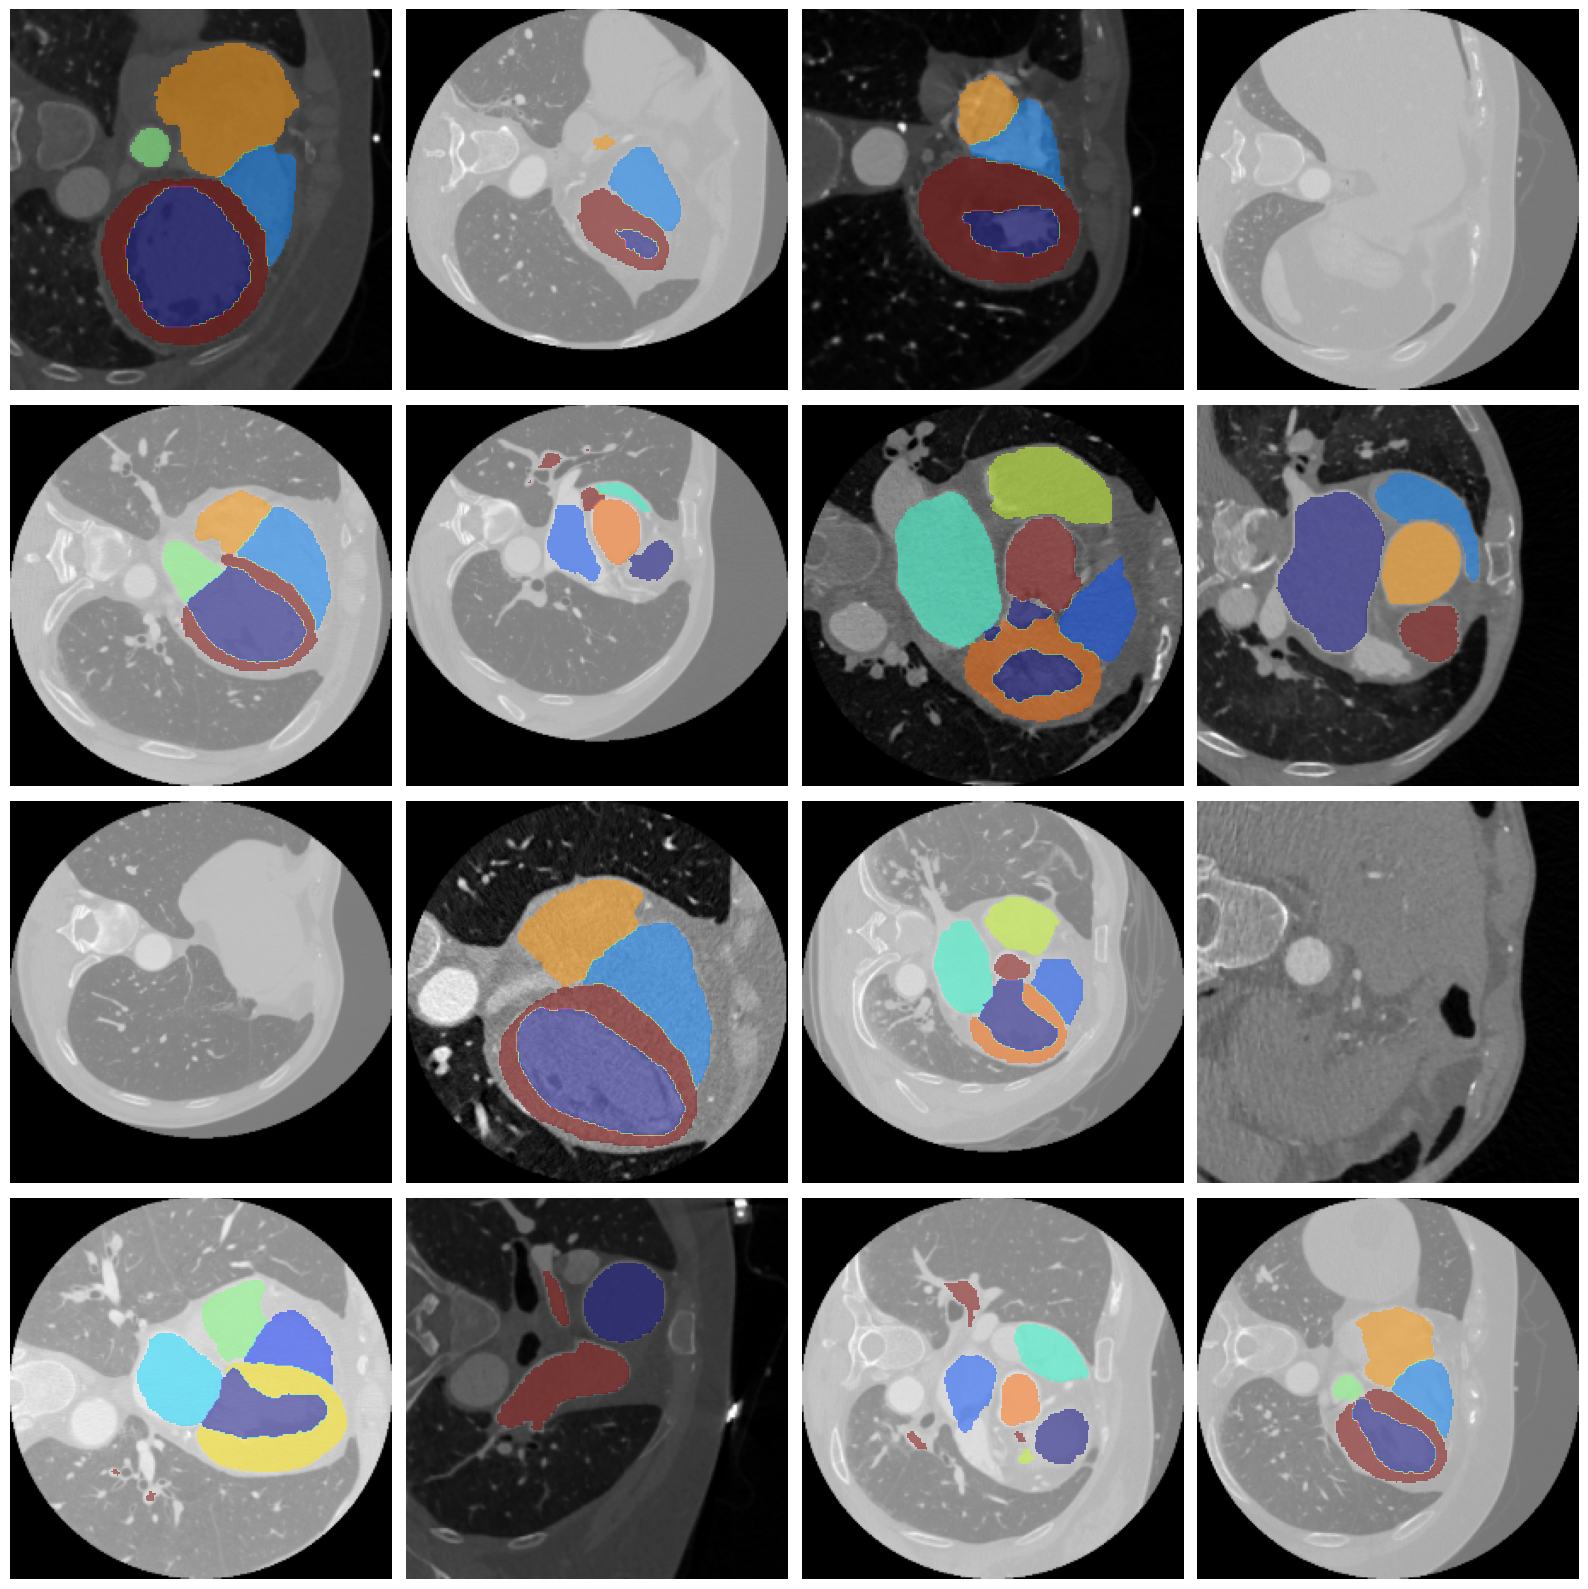

In [ ]:
 ############### basic CT dataloader without augmentation
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A

# Dataset class
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, trans=None, num_classes=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.trans = trans
        self.num_classes = num_classes

        # List images and masks
        self.path_image = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
        self.path_mask = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

    def __getitem__(self, idx):
        image = np.array(Image.open(self.path_image[idx]))
        mask = cv2.imread(self.path_mask[idx], 0)

        if self.trans:
            augmented = self.trans(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        img_t = torch.from_numpy(image).float().unsqueeze(0)  # [1,H,W]
        mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()
        return img_t, mask_t

    def __len__(self):
        return len(self.path_image)

# Paths
image_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_images"
mask_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_masks"

# Optional augmentations
transform = A.Compose([
    A.Resize(224, 224),
])

# Create dataset and dataloader
dataset = Segmentation_Dataset(image_folder, mask_folder, trans=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Take one batch
imgs, masks = next(iter(dataloader))  # imgs: [B,1,H,W], masks: [B,num_classes,H,W]

# Plot batch
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for i in range(rows):
    for j in range(cols):
        idx = i*cols + j
        if idx >= imgs.shape[0]:
            break

        ax = axes[i, j]
        img = imgs[idx][0].numpy()
        mask = torch.argmax(masks[idx], dim=0).numpy()  # convert one-hot back to class indices

        ax.imshow(img, cmap='gray')
        mask_display = np.ma.masked_where(mask == 0, mask)  # hide background
        ax.imshow(mask_display, alpha=0.5, cmap='jet')
        ax.axis('off')

plt.tight_layout()
plt.show()


8193
torch.Size([25, 1, 224, 224]) torch.Size([25, 8, 224, 224])
[0. 1.]
8


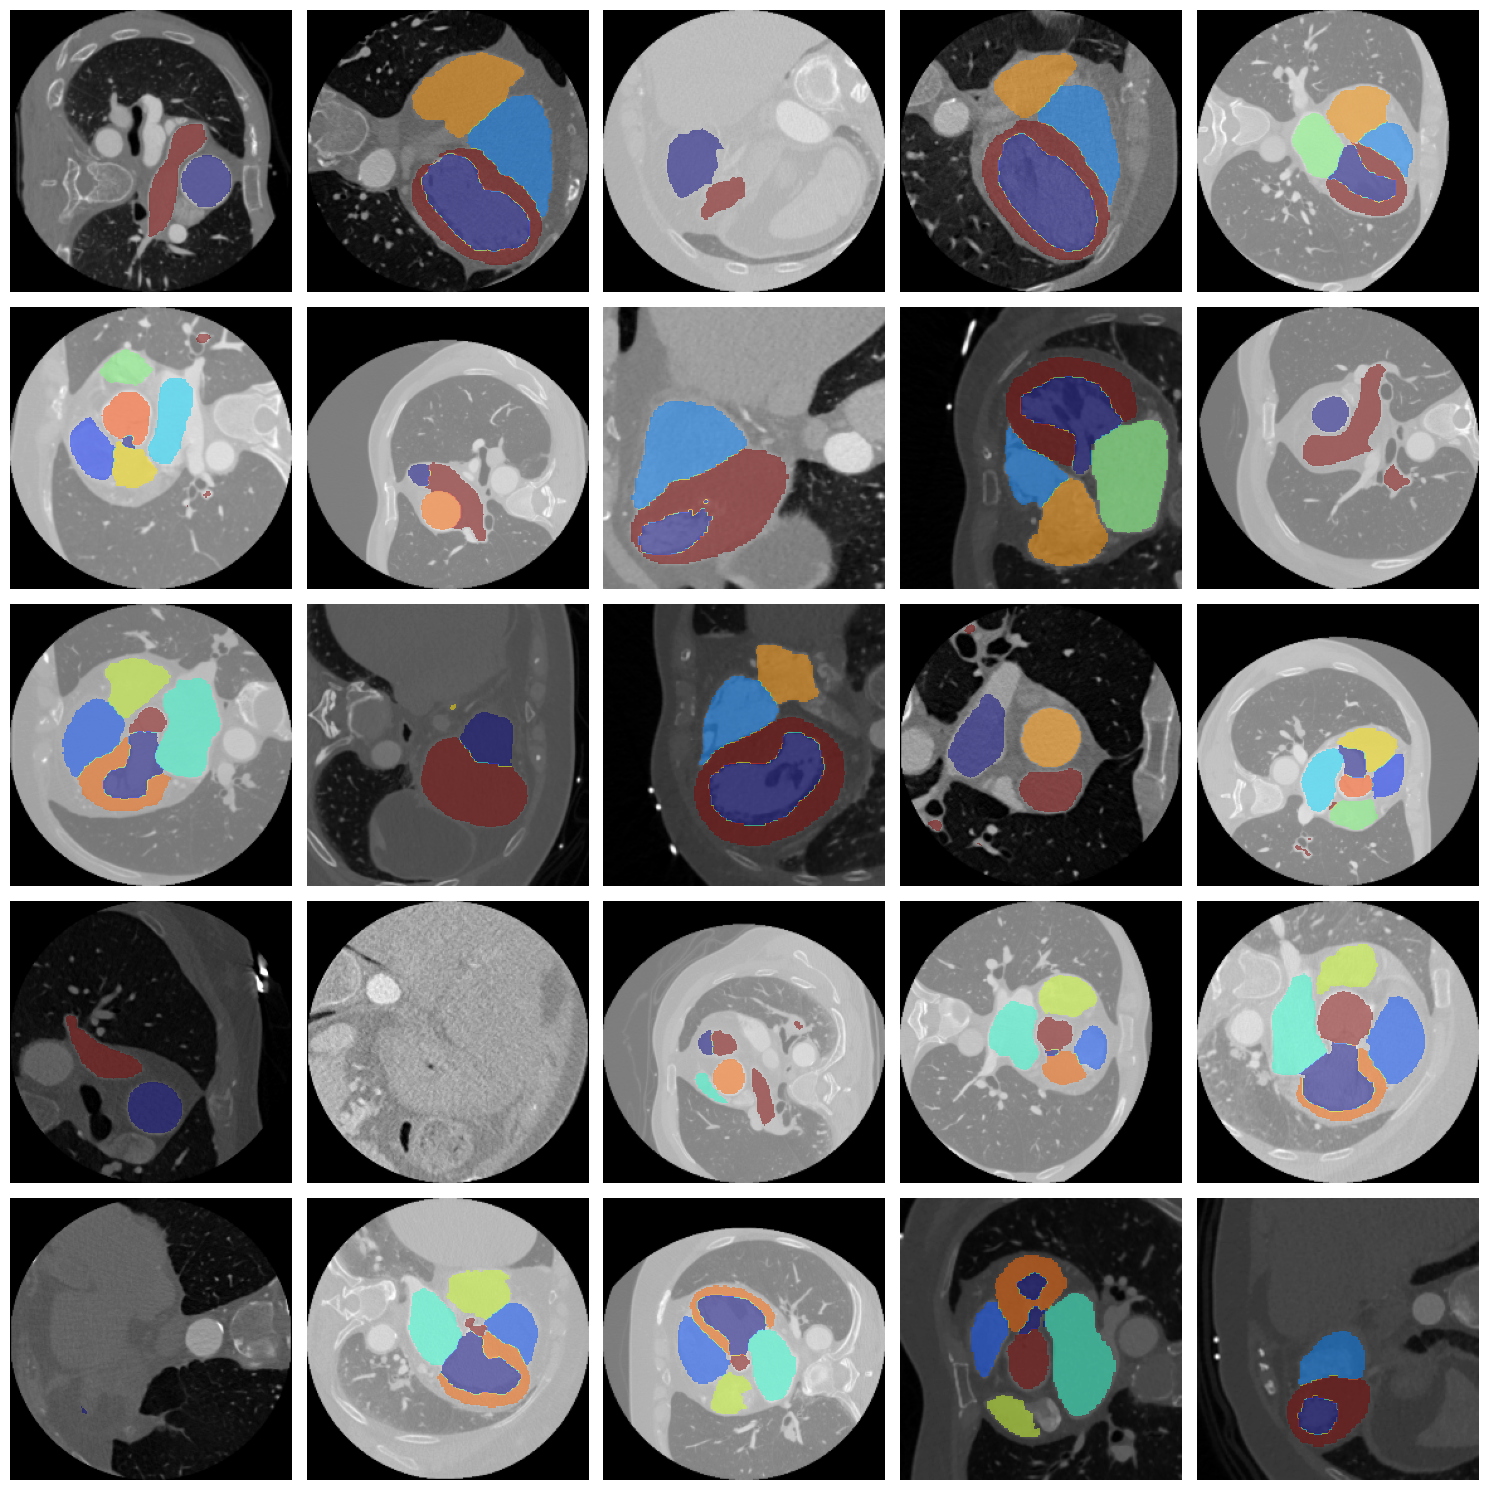

In [4]:
 ### dataloader with augmentation
import torch 
import cv2
import os
from torch.utils.data import Dataset
import albumentations as A  # no need for functional import
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, trans=None, num_classes=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.trans = trans
        self.num_classes = num_classes

        # List images
        self.path_image = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]
        # List masks
        self.path_mask = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")]

    def __getitem__(self, idx):
        image = np.array(Image.open(self.path_image[idx]))
        mask = cv2.imread(self.path_mask[idx], 0)  # grayscale mask

        # Apply augmentation if any
        if self.trans:
            augmented = self.trans(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to torch tensors
        img_t = torch.from_numpy(image).float().unsqueeze(0)  # [C,H,W], single channel
        mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()

        return img_t, mask_t

    def __len__(self):
        return len(self.path_image)


# Example usage
image_folder_train = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_images"
mask_folder_train = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_masks"

transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

dataset_train = Segmentation_Dataset(image_folder_train, mask_folder_train, trans=transform_train)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=25, shuffle=True)
print(len(dataset_train))
imgs, masks = next(iter(dataloader))
print(imgs.shape, masks.shape)
print(np.unique(masks))

#################### plot this ######
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming imgs and masks are from your DataLoader
batch_size = imgs.shape[0]
num_classes = masks.shape[1]
print(num_classes)

# Plot grid
rows, cols = 5, 5  # adjust to batch size
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

for i in range(rows):
    for j in range(cols):
        idx = i*cols + j
        if idx >= batch_size:
            break
        
        ax = axes[i, j]
        img = imgs[idx][0].numpy()  # [C,H,W] -> [H,W], single channel
        mask = torch.argmax(masks[idx], dim=0).numpy()  # [num_classes,H,W] -> [H,W]

        ax.imshow(img, cmap="gray")
        # overlay mask with transparency
        mask_display = np.ma.masked_where(mask == 0, mask)  # hide background
        ax.imshow(mask_display, alpha=0.5, cmap="jet")
        ax.axis('off')

plt.tight_layout()
plt.show()





In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# -----------------------------
# Step 0: Define source folders
# -----------------------------
image_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_images"
mask_folder = "/mnt/ssd_pool/ST_foundation_models/basic_dinov2/models_basics/CT_2Ddataset/2d_masks"

# -----------------------------
# Step 1: Create train/val folders
# -----------------------------
base_dir = "/mnt/ssd_pool/CT_2Ddataset"
train_image_dir = os.path.join(base_dir, "train/images")
train_mask_dir = os.path.join(base_dir, "train/masks")
val_image_dir = os.path.join(base_dir, "val/images")
val_mask_dir = os.path.join(base_dir, "val/masks")

for folder in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir]:
    os.makedirs(folder, exist_ok=True)

# -----------------------------
# Step 2: Match images and masks
# -----------------------------
all_images = [f for f in os.listdir(image_folder) if f.endswith(".png")]
all_masks = [f for f in os.listdir(mask_folder) if f.endswith(".png")]

image_prefix_to_mask = {f.split(".png")[0]: f for f in all_masks}
matched_images, matched_masks = [], []

for img_file in all_images:
    prefix = img_file.split(".png")[0]
    if prefix in image_prefix_to_mask:
        matched_images.append(img_file)
        matched_masks.append(image_prefix_to_mask[prefix])

# -----------------------------
# Step 3: Split into train/val
# -----------------------------
train_images, val_images, train_masks, val_masks = train_test_split(
    matched_images, matched_masks, test_size=0.2, random_state=42
)

# -----------------------------
# Step 4: Copy files
# -----------------------------
for src_img, src_mask in zip(train_images, train_masks):
    shutil.copy(os.path.join(image_folder, src_img), train_image_dir)
    shutil.copy(os.path.join(mask_folder, src_mask), train_mask_dir)

for src_img, src_mask in zip(val_images, val_masks):
    shutil.copy(os.path.join(image_folder, src_img), val_image_dir)
    shutil.copy(os.path.join(mask_folder, src_mask), val_mask_dir)

print(f"Train: {len(train_images)} images, Val: {len(val_images)} images")

# -----------------------------
# Step 5: Define Dataset
# -----------------------------
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, trans=None, num_classes=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.trans = trans
        self.num_classes = num_classes
        self.path_image = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]
        self.path_mask = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")]

    def __getitem__(self, idx):
        image = np.array(Image.open(self.path_image[idx]))
        mask = cv2.imread(self.path_mask[idx], 0)  # grayscale mask

        if self.trans:
            augmented = self.trans(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        img_t = torch.from_numpy(image).float().unsqueeze(0)
        mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()

        return img_t, mask_t

    def __len__(self):
        return len(self.path_image)

# -----------------------------
# Step 6: Define augmentations
# -----------------------------
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

transform_val = A.Compose([
    A.Resize(224, 224)
])

# -----------------------------
# Step 7: Load Dataset and DataLoader
# -----------------------------
train_dataset = Segmentation_Dataset(train_image_dir, train_mask_dir, trans=transform_train)
val_dataset = Segmentation_Dataset(val_image_dir, val_mask_dir, trans=transform_val)

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=False)

# -----------------------------
# Step 8: Visualize one batch
# -----------------------------
imgs, masks = next(iter(train_loader))
batch_size = imgs.shape[0]
num_classes = masks.shape[1]

rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for i in range(rows):
    for j in range(cols):
        idx = i*cols + j
        if idx >= batch_size:
            break
        ax = axes[i, j]
        img = imgs[idx][0].numpy()
        mask = torch.argmax(masks[idx], dim=0).numpy()
        ax.imshow(img, cmap="gray")
        mask_display = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask_display, alpha=0.5, cmap="jet")
        ax.axis('off')
plt.tight_layout()
plt.show()
